In [1]:
#pull data from finance yahoo news using api, convert the file to json and then a list of all news for a particular stocks, for this example, tesla. 
import requests
!pip install newsapi-python
from newsapi import NewsApiClient
from urllib.request import urlopen, Request
!pip install bs4
from bs4 import BeautifulSoup
import json
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
!pip install TextBlob
from textblob import TextBlob
#!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

url = "https://rapidapi.p.rapidapi.com/api/yahoo/ne/news/tsla"

headers = {
    'x-rapidapi-host': "yahoo-finance15.p.rapidapi.com",
    'x-rapidapi-key': "fe6bbed556msh5d9a20764b8f0cbp1f0d22jsnc1e17707cacf"
    }

response = requests.request("GET", url, headers=headers)
json_file = response.json()
List_of_news = json_file['item']
print(List_of_news)


[{'description': 'Dow Jones futures were in focus late Tuesday, as the coronavirus stimulus deadline looms. Netflix and Snap reported earnings.', 'guid': 'f80675a8-ca9b-35df-8cbf-0992f7088530', 'link': 'https://finance.yahoo.com/m/f80675a8-ca9b-35df-8cbf-0992f7088530/dow-jones-futures%3A-stock.html?.tsrc=rss', 'pubDate': 'Wed, 21 Oct 2020 02:18:11 +0000', 'title': 'Dow Jones Futures: Stock Market Rally Hits Pelosi Stimulus Deadline; Netflix Dives, While Snap Rockets 24% On Earnings'}, {'description': 'COMPANY CLOSE UPDATES  Terrence Horan Shares of Tesla Inc. TSLA shed 2.06% to $421.94 Tuesday, on what proved to be an all-around positive trading session for the stock market, with the NASDAQ Composite Index COMP rising 0.', 'guid': '18e06b4c-db85-399b-a4d9-14d8d1229ee9', 'link': 'https://finance.yahoo.com/m/18e06b4c-db85-399b-a4d9-14d8d1229ee9/tesla-inc.-stock.html?.tsrc=rss', 'pubDate': 'Tue, 20 Oct 2020 20:25:00 +0000', 'title': 'Tesla Inc. stock underperforms Tuesday when compared to

In [2]:
#pull data from yahoo finance for tesla's stock history
url = "https://rapidapi.p.rapidapi.com/api/yahoo/hi/history/tsla/15m"

headers = {
    'x-rapidapi-host': "yahoo-finance15.p.rapidapi.com",
    'x-rapidapi-key': "fe6bbed556msh5d9a20764b8f0cbp1f0d22jsnc1e17707cacf"
    }

response = requests.request("GET", url, headers=headers)
#print(response.text)
tsla_file = response.json()
tsla_stock_price_list = tsla_file['items']
print(tsla_stock_price_list)

{'1600695000': {'date': '21-09-2020', 'open': 453.13, 'high': 455.68, 'low': 443.53, 'close': 449.59}, '1600695900': {'date': '21-09-2020', 'open': 449.59, 'high': 453.3, 'low': 446.99, 'close': 448.31}, '1600696800': {'date': '21-09-2020', 'open': 448.45, 'high': 450.47, 'low': 444.95, 'close': 447.11}, '1600697700': {'date': '21-09-2020', 'open': 447.12, 'high': 448.89, 'low': 430, 'close': 430.67}, '1600698600': {'date': '21-09-2020', 'open': 430.93, 'high': 432.85, 'low': 407.07, 'close': 417.94}, '1600699500': {'date': '21-09-2020', 'open': 417.97, 'high': 428.6, 'low': 417.42, 'close': 426.45}, '1600700400': {'date': '21-09-2020', 'open': 426.4, 'high': 437.2, 'low': 426.14, 'close': 431.19}, '1600701300': {'date': '21-09-2020', 'open': 431.36, 'high': 437.99, 'low': 427.7, 'close': 434.4}, '1600702200': {'date': '21-09-2020', 'open': 434.45, 'high': 436.48, 'low': 430.31, 'close': 432.52}, '1600703100': {'date': '21-09-2020', 'open': 432.53, 'high': 440.6, 'low': 432.2, 'close':

In [3]:
#make a dataframe using the list tsla_stock_price_list, which is a list of dictionaries
tsla_stock_df=pd.DataFrame(tsla_stock_price_list).T[['date','close']]
tsla_stock_df['date'] =pd.to_datetime(tsla_stock_df['date'], format='%d-%m-%Y')
tsla_stock_df['close']=tsla_stock_df['close'].astype(float)

tsla_stock_df=tsla_stock_df.groupby('date')[['close']].median().reset_index()
#tsla_stock_df['date']=tsla_stock_df['date'].dt.strftime('%Y-%m-%d')
#print(tsla_stock_df.dtypes)
print(tsla_stock_df)

         date    close
0  2020-09-21  443.100
1  2020-09-22  427.000
2  2020-09-23  389.270
3  2020-09-24  391.295
4  2020-09-25  403.110
5  2020-09-28  419.780
6  2020-09-29  422.950
7  2020-09-30  429.140
8  2020-10-01  442.920
9  2020-10-02  425.200
10 2020-10-05  424.110
11 2020-10-06  418.255
12 2020-10-07  425.360
13 2020-10-08  431.805
14 2020-10-09  432.705
15 2020-10-12  443.310
16 2020-10-13  445.690
17 2020-10-14  460.555
18 2020-10-15  447.680
19 2020-10-16  448.205
20 2020-10-19  438.240
21 2020-10-20  423.720


In [4]:
#clean data, convert date into datetime format and split date with time. 
vader = SentimentIntensityAnalyzer()
result_df=pd.DataFrame()
for each_news in List_of_news:
    #each_news['pubDate']=datetime.fromisoformat(each_news['pubDate'])
    each_news['pubDate'] = datetime.strptime(each_news['pubDate'], '%a, %d %b %Y %H:%M:%S %z')
    df = pd.DataFrame(each_news, index=[0])
    df['date'] = [d.date() for d in df['pubDate']]
    scores = df['description'].apply(vader.polarity_scores).tolist()
    df_each_news = df[['date','title']]
    scores_df = pd.DataFrame(scores)

    # Join the DataFrames of the news and the list of dicts
    parsed_and_scored_news = df_each_news.join(scores_df, rsuffix='_right')
    result_df = pd.concat([result_df,parsed_and_scored_news])
    #print(scores)
result_df = result_df.sort_values('date')
result_df['date'] =pd.to_datetime(result_df['date'], format='%Y-%m-%d')
print(result_df) 

        date                                              title    neg    neu  \
0 2020-10-20  Ahead of Q3 Earnings, Tesla Sees Mixed Picture...  0.033  0.929   
0 2020-10-20  Why You Should Buy Tesla ETFs Ahead of Q3 Earn...  0.085  0.763   
0 2020-10-20  GM to Plan Third Electric-Vehicle Plant in Big...  0.013  0.892   
0 2020-10-20  Dow Jones Jumps 250 Points On Coronavirus Stim...  0.000  0.844   
0 2020-10-20  Tesla Service Bulletin Addresses Issue Of Bump...  0.079  0.847   
0 2020-10-20  Tesla&#39;s Key Trading Levels to Know Ahead o...  0.000  1.000   
0 2020-10-20  Dow Jones Up 200 Points On Stimulus Deal Hopes...  0.000  0.726   
0 2020-10-20  Logitech Pulls Nasdaq Higher; Tesla Braces for...  0.036  0.855   
0 2020-10-20                      Tesla In Park Before Earnings  0.000  1.000   
0 2020-10-20  Dow Jones Rallies As Pelosi Stimulus Deadline ...  0.000  1.000   
0 2020-10-20  The Zacks Analyst Blog Highlights: General Mot...  0.000  1.000   
0 2020-10-20  How To Trade T

In [5]:
#merge the stock price dataframe with sentiment scores dataframe
stock_sentiment_df = pd.merge(left=tsla_stock_df, right=result_df, how='outer', left_on='date', right_on='date')
print(stock_sentiment_df)

         date    close                                              title  \
0  2020-09-21  443.100                                                NaN   
1  2020-09-22  427.000                                                NaN   
2  2020-09-23  389.270                                                NaN   
3  2020-09-24  391.295                                                NaN   
4  2020-09-25  403.110                                                NaN   
5  2020-09-28  419.780                                                NaN   
6  2020-09-29  422.950                                                NaN   
7  2020-09-30  429.140                                                NaN   
8  2020-10-01  442.920                                                NaN   
9  2020-10-02  425.200                                                NaN   
10 2020-10-05  424.110                                                NaN   
11 2020-10-06  418.255                                                NaN   

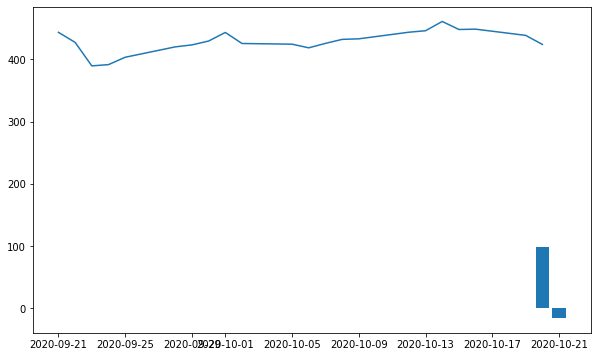

In [6]:
#visualization
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and calculate the mean
#mean_scores = stock_sentiment_df.groupby(['date']).mean()

# Unstack the column ticker
#mean_scores = mean_scores.unstack()

plt.plot(stock_sentiment_df['date'], stock_sentiment_df['close'])
# Plot a bar chart with pandas
plt.bar(stock_sentiment_df['date'],stock_sentiment_df['compound']*100)
plt.show()

In [7]:
#use a different library textblob to compute sentiment scores
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
result_textblob_df=pd.DataFrame()
for news in List_of_news:
    #each_news['pubDate']=datetime.fromisoformat(each_news['pubDate'])
    #print(news)
    #news['pubDate'] = datetime.strptime(news['pubDate'], '%a, %d %b %Y %H:%M:%S %z')
    df = pd.DataFrame(news, index=[0])
    df['date'] = [d.date() for d in df['pubDate']]
    scores = df['description'].apply(getPolarity).tolist()
    df_each_news = df[['date','title']]
    scores_df = pd.DataFrame(scores)

    # Join the DataFrames of the news and the list of dicts
    parsed_and_scored_news = df_each_news.join(scores_df, rsuffix='_right')
    result_textblob_df = pd.concat([result_textblob_df,parsed_and_scored_news])
result_textblob_df = result_textblob_df.sort_values('date')
print(result_textblob_df)

         date                                              title         0
0  2020-10-20  Ahead of Q3 Earnings, Tesla Sees Mixed Picture...  0.124074
0  2020-10-20  Why You Should Buy Tesla ETFs Ahead of Q3 Earn...  0.159091
0  2020-10-20  GM to Plan Third Electric-Vehicle Plant in Big...  0.097968
0  2020-10-20  Dow Jones Jumps 250 Points On Coronavirus Stim... -0.150000
0  2020-10-20  Tesla Service Bulletin Addresses Issue Of Bump...  0.144238
0  2020-10-20  Tesla&#39;s Key Trading Levels to Know Ahead o...  0.000000
0  2020-10-20  Dow Jones Up 200 Points On Stimulus Deal Hopes... -0.012500
0  2020-10-20  Logitech Pulls Nasdaq Higher; Tesla Braces for...  0.266667
0  2020-10-20                      Tesla In Park Before Earnings  0.095238
0  2020-10-20  Dow Jones Rallies As Pelosi Stimulus Deadline ...  0.000000
0  2020-10-20  The Zacks Analyst Blog Highlights: General Mot...  0.050000
0  2020-10-20  How To Trade The Netflix And Tesla Earnings Re...  0.047840
0  2020-10-20  Can Tesla 

In [8]:
#since yahoo finance only provides financial news for two days, 9/8/2020 and 9/9/2020
#it is insufficient to use it to create a model, now try news data from finviz

tesla_url = 'https://finviz.com/quote.ashx?t=tsla'
req = Request(url=tesla_url, headers={'user-agent': 'my-app'})
response = urlopen(req)
tsla_html = BeautifulSoup(response, 'html')
tsla_news_table = tsla_html.find(id='news-table')
tsla_news = tsla_news_table.findAll('tr')      #extract news section from the html
#print(tsla_news)

In [9]:
#extract the timestamp and news headline 
import re
import string
tsla_news_data = []
for row in tsla_news:
    title = row.a.text
    date_list = row.td.text.split(' ')
    #date = re.sub('\D', '', date).split(' ')
    print(date_list)
    if len(date_list)==1:
        time = date_list[0]
    else:
        date = date_list[0]
        time = date_list[1]
    tsla_news_data.append([date, time, title])    
print(tsla_news_data)

['Oct-20-20', '10:18PM\xa0\xa0']
['08:30PM\xa0\xa0']
['04:49PM\xa0\xa0']
['04:25PM\xa0\xa0']
['04:10PM\xa0\xa0']
['04:07PM\xa0\xa0']
['04:02PM\xa0\xa0']
['03:54PM\xa0\xa0']
['03:45PM\xa0\xa0']
['03:05PM\xa0\xa0']
['02:57PM\xa0\xa0']
['02:19PM\xa0\xa0']
['01:46PM\xa0\xa0']
['01:40PM\xa0\xa0']
['01:32PM\xa0\xa0']
['12:51PM\xa0\xa0']
['12:30PM\xa0\xa0']
['12:20PM\xa0\xa0']
['12:06PM\xa0\xa0']
['12:01PM\xa0\xa0']
['11:50AM\xa0\xa0']
['10:43AM\xa0\xa0']
['10:24AM\xa0\xa0']
['10:17AM\xa0\xa0']
['10:12AM\xa0\xa0']
['10:12AM\xa0\xa0']
['10:08AM\xa0\xa0']
['10:00AM\xa0\xa0']
['09:56AM\xa0\xa0']
['09:33AM\xa0\xa0']
['08:38AM\xa0\xa0']
['08:18AM\xa0\xa0']
['07:07AM\xa0\xa0']
['07:00AM\xa0\xa0']
['06:06AM\xa0\xa0']
['04:13AM\xa0\xa0']
['Oct-19-20', '10:32PM\xa0\xa0']
['10:20PM\xa0\xa0']
['08:03PM\xa0\xa0']
['06:52PM\xa0\xa0']
['05:06PM\xa0\xa0']
['04:26PM\xa0\xa0']
['04:15PM\xa0\xa0']
['03:46PM\xa0\xa0']
['03:04PM\xa0\xa0']
['02:32PM\xa0\xa0']
['12:03PM\xa0\xa0']
['12:02PM\xa0\xa0']
['11:40AM\xa0\

In [10]:
#now compute sentiment scores
df =pd.DataFrame(tsla_news_data,columns=['date','time','title'])
#print(df)
vader = SentimentIntensityAnalyzer()
f = lambda title: vader.polarity_scores(title)['compound'] # only compute the 'compound' component 
df['compound'] = df['title'].apply(f)
df['date'] =pd.to_datetime(df['date'])
print(df)

         date       time                                              title  \
0  2020-10-20  10:18PM    Dow Jones Futures: Stock Market Rally Hits Pel...   
1  2020-10-20  08:30PM    GMC reveals the Hummer EV: 1,000 HP, 350 mile ...   
2  2020-10-20  04:49PM       GM to launch all-electric hummer Tuesday night   
3  2020-10-20  04:25PM    Tesla Inc. stock underperforms Tuesday when co...   
4  2020-10-20  04:10PM    GM Is About To Reveal Its Answer To Tesla's Cy...   
..        ...        ...                                                ...   
95 2020-10-15  12:07PM    Dow Jones Dives 325 Points, As Jobless Claims ...   
96 2020-10-15  11:56AM               Competition Increasing In The EV Space   
97 2020-10-15  11:35AM    China-Made Tesla Model Y Could Reach 360K Unit...   
98 2020-10-15  11:30AM    Renault Bolsters Electric-Car Lineup After Squ...   
99 2020-10-15  10:29AM    Tesla, Amazon, Nvidia May Be 'Extravagantly Pr...   

    compound  
0     0.0000  
1     0.0000  
2     

In [11]:
#merge with dataframe of tesla daily stock price
tsla_df = df.merge(tsla_stock_df, how='inner', on='date')
tsla_df=tsla_df[['date','compound','close']]
tsla_df=tsla_df.groupby('date').agg({'compound':'mean','close':'mean'})
print(tsla_df)

            compound    close
date                         
2020-10-15  0.017340  447.680
2020-10-16  0.089267  448.205
2020-10-19  0.000026  438.240
2020-10-20  0.043706  423.720


## get news data using news api
api = NewsApiClient(api_key='9ab1bcf601ca4f80b15327966b2c3229')
tsla_articles = api.get_everything(q='tesla', sources = 'bbc news, metro, financial-times, business insider, yahoo finance, reuters, bloomberg,cnbc,fortune,cbc-news',
                                   from_param='2020-09-01', to='2020-10-20',
                                   language='en'
                                   )

In [12]:
'''api = NewsApiClient(api_key='9ab1bcf601ca4f80b15327966b2c3229') 
tsla_articles = api.get_everything(everything?q='tesla', sources = 'bbc news,finviz, metro, financial-times, business insider, yahoo finance, reuters, bloomberg,cnbc,fortune,cbc-news', 
                                   from_param='2020-09-20', to='2020-10-20', 
                                   language='en' 
                                  )
print(len(tsla_articles['articles']))'''
api_key = '92ca98e398914d28a60d029d8bfc40af'
url = 'https://newsapi.org/v2/everything?q=tesla'

parameters = { 
             'q':'tesla',
             'pagesize':100,
              'apiKey':api_key,
              'language':'en',
              'from':'2020-09-20'
              }
tsla_articles = requests.get(url, params = parameters).json()
print(len(tsla_articles['articles']))

100


In [13]:
#extract news from the list tsla_articles['articles']
dic_tsla={'title':[],'date':[]}
for news in tsla_articles['articles']:
    dic_tsla['title'].append(news['title'])
    dic_tsla['date'].append(news['publishedAt'])
tsla_news = pd.DataFrame(dic_tsla,columns=['date','title']).sort_values('date').reset_index()
del tsla_news['index']

tsla_news['date'] = pd.to_datetime(tsla_news['date'])
tsla_news['date'] = [d.date() for d in tsla_news['date']]
print(tsla_news)

          date                                              title
0   2020-09-20  Tesla Driver Caught Going 100 MPH While Fast A...
1   2020-09-21  Musk says 'Battery Day' unveil will not reach ...
2   2020-09-21  How to Watch Tesla’s Battery Day Event—and Wha...
3   2020-09-22  Musk sees no immediate boost from 'Battery Day...
4   2020-09-22  Elon Musk: Tesla Battery Day tech won't be mas...
..         ...                                                ...
95  2020-10-20  Tesla analysts hope for Musk sign on 2020 deli...
96  2020-10-20  Tesla analysts hope for Musk sign on 2020 deli...
97  2020-10-20  Tesla analysts hope for Musk sign on 2020 deli...
98  2020-10-21  GMC reveals the Hummer EV: 1,000 HP, 350 mile ...
99  2020-10-21  Watch GM unveil the $80,000 GMC Hummer EV righ...

[100 rows x 2 columns]


In [14]:
#compute sentiment scores
vader = SentimentIntensityAnalyzer()
f = lambda title: vader.polarity_scores(title)['compound'] # only compute the 'compound' component 
tsla_news['compound'] = df['title'].apply(f)
tsla_news['date'] = pd.to_datetime(tsla_news['date'])
print(tsla_news.dtypes)

date        datetime64[ns]
title               object
compound           float64
dtype: object


In [15]:
#merge with dataframe of tesla daily stock price
tsla_news_sentiment = tsla_news.merge(tsla_stock_df, how='inner', on='date')
tsla_news_sentiment=tsla_news_sentiment[['date','compound','close']]
tsla_news_sentiment=tsla_news_sentiment.groupby('date').agg({'compound':'mean','close':'mean'})
print(tsla_news_sentiment)
print(tsla_news_sentiment.shape)

            compound    close
date                         
2020-09-21  0.000000  443.100
2020-09-22  0.088592  427.000
2020-09-23 -0.014875  389.270
2020-09-24  0.131940  391.295
2020-09-28 -0.273200  419.780
2020-09-29  0.053850  422.950
2020-09-30  0.000000  429.140
2020-10-01 -0.059300  442.920
2020-10-02  0.068000  425.200
2020-10-05  0.084750  424.110
2020-10-06  0.000000  418.255
2020-10-07 -0.042667  425.360
2020-10-08  0.019300  431.805
2020-10-09 -0.063025  432.705
2020-10-12  0.000000  443.310
2020-10-13  0.416800  445.690
2020-10-14 -0.074000  460.555
2020-10-15  0.101150  447.680
2020-10-16  0.134867  448.205
2020-10-19  0.063640  438.240
2020-10-20 -0.154267  423.720
(21, 2)


In [16]:
#create a column called price_change, indicate increase or decrease of stock price
tsla_news_sentiment['price_change']=0
#tsla_news_sentiment['price_change']=tsla_news_sentiment['price_change'].fillna(0).astype(int)
tsla_news_sentiment.iloc[0,2]=1 #since tsla stock increased from 2020-9-18 to 2020-9-21
begin_price=443.100
for index,price in enumerate(tsla_news_sentiment['close'][1:]):
    if price> begin_price:
        tsla_news_sentiment.iloc[index+1,2]=1
    else:
        tsla_news_sentiment.iloc[index+1,2]=0
    begin_price = price
print(tsla_news_sentiment)    
    

            compound    close  price_change
date                                       
2020-09-21  0.000000  443.100             1
2020-09-22  0.088592  427.000             0
2020-09-23 -0.014875  389.270             0
2020-09-24  0.131940  391.295             1
2020-09-28 -0.273200  419.780             1
2020-09-29  0.053850  422.950             1
2020-09-30  0.000000  429.140             1
2020-10-01 -0.059300  442.920             1
2020-10-02  0.068000  425.200             0
2020-10-05  0.084750  424.110             0
2020-10-06  0.000000  418.255             0
2020-10-07 -0.042667  425.360             1
2020-10-08  0.019300  431.805             1
2020-10-09 -0.063025  432.705             1
2020-10-12  0.000000  443.310             1
2020-10-13  0.416800  445.690             1
2020-10-14 -0.074000  460.555             1
2020-10-15  0.101150  447.680             0
2020-10-16  0.134867  448.205             1
2020-10-19  0.063640  438.240             0
2020-10-20 -0.154267  423.720   

In [18]:
#feature data set
X = tsla_news_sentiment
X = np.array(X.drop(['price_change'],1))
#target data
Y = np.array(tsla_news_sentiment['price_change'])

In [19]:
#split to 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [20]:
#train the model
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [21]:
#do prediction
prediction = model.predict(x_test)
prediction

array([1, 1, 1, 1, 1], dtype=int64)

In [22]:
y_test

array([0, 1, 0, 0, 1], dtype=int64)

In [23]:
#show model performance
print(classification_report(y_test,prediction)) #performance is bad because the training size is simply too small

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



C:\Users\zcj10\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
